# Materials Informatics with the Materials Project API

By Wenhao Sun, Assistant Professor of Materials Science and Engineering, University of Michigan

Last updated May 28th, 2023

## Introduction

As discussed in lecture, the Cross-Industry Standard Process for Data Mining (CRISP-DM) spans the following steps: 


<div style="float: left; margin-right: 20px;">
  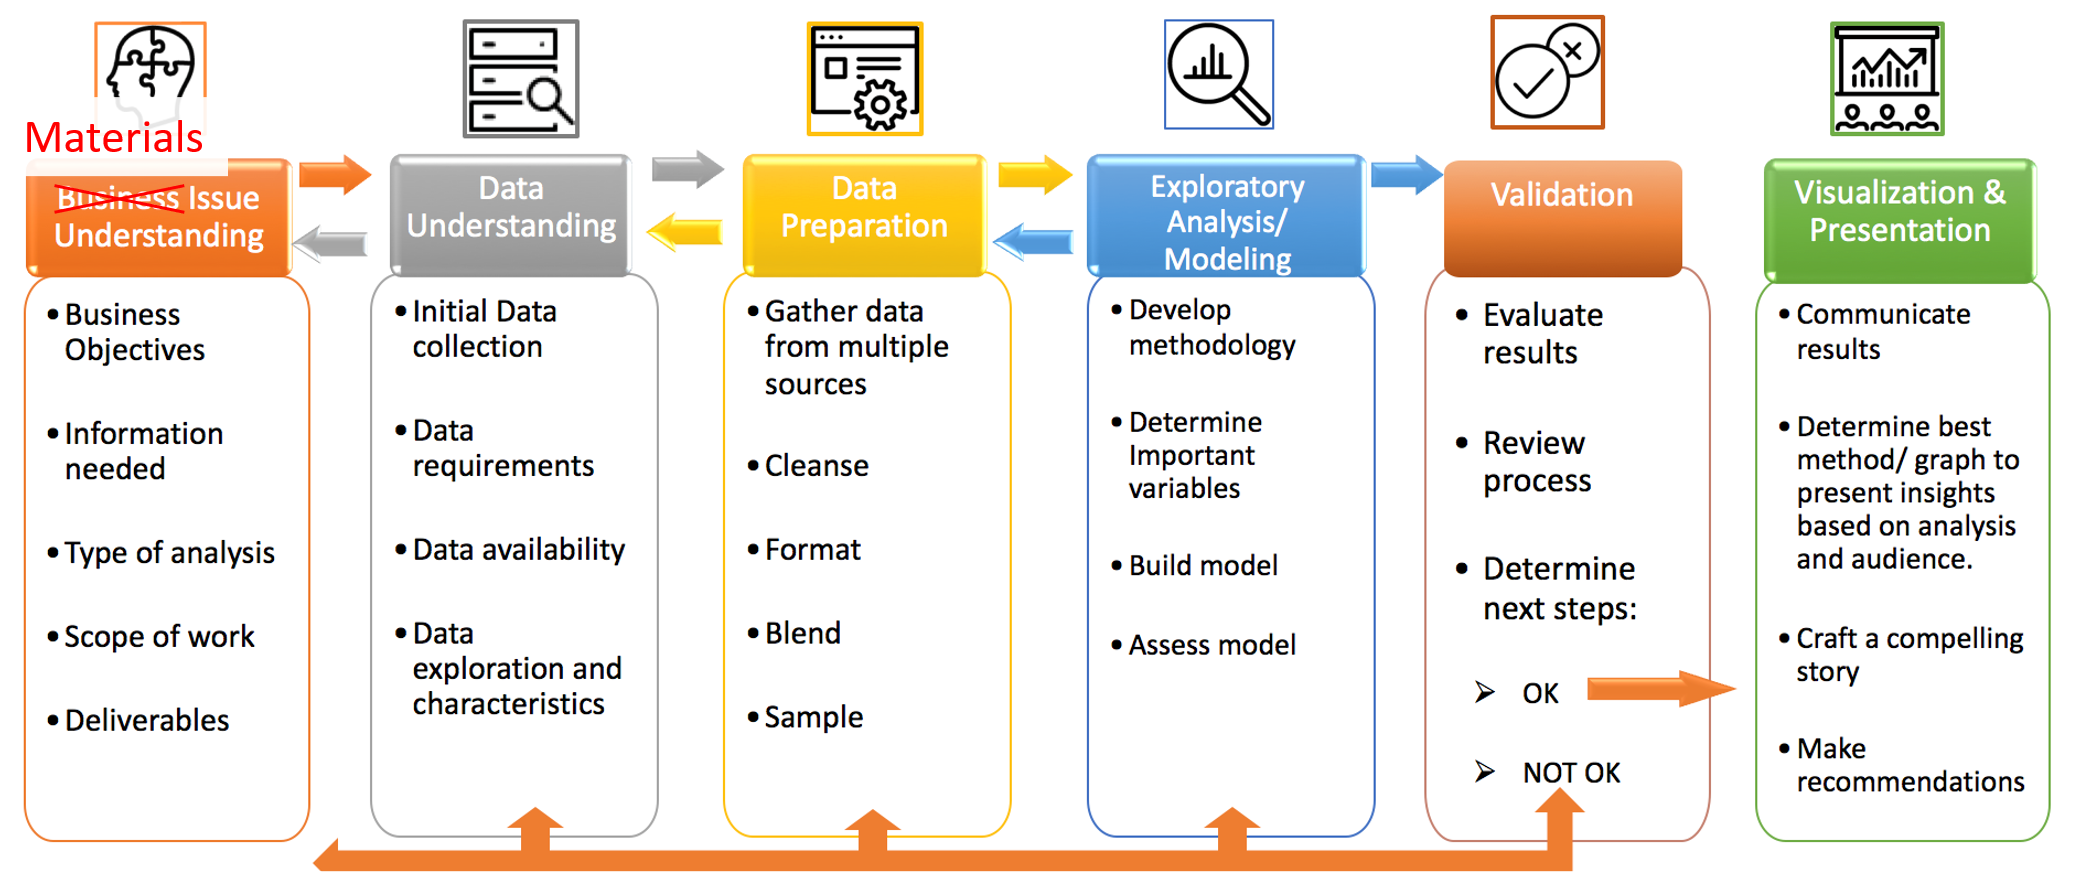
</div>


<div style="clear: left;">
    
In this lab, we will learn the Python coding skills to execute the steps "Data Understanding", "Data Preparation" and "Exploratory Analysis". These are important techniques to learn computationally, but as always, executing exciting  data science analyses relies on your *materials science insights*--that is, to pose interesting scientific questions (Materials Understanding), and to build compelling stories from broad swaths of data (Visualization and Presentation). 

This lab uses a Jupyter notebook, where blocks of code are interspersed between blocks of instructional text. If you don't know Python yet, you should still be able to follow along the general structure. I would recommend learning Python later -- it is easy to pick up, and there are tons of instructional resources online. 

To run code in the Jupyter notebook, select a block and click the 'Run' button above. The code will be run in-place, and the variables will be stored for later cells as well. 

Jupyter is valuable to teach sample code in short digestable chunks. However, when you start to develop larger analysis scripts, Jupyter notebooks become very limited. At this point, you should migrate to an Integrated Developer Environment like Pycharm or Visual Studio Code for your more extensive analyses. 
 
</div>


## Data Understanding

### Introduction to the Materials Project

The Materials Project is a free-to-access online database that contains density functional theory (DFT) calculations for over 120,000+ materials. For many of these materials, properties such as electronic band structures, phonon bandstructures, elastic constants, and surface energies have also been calculated. 

Before executing this project, you should make a free account on the Materials Project, and spend some time exploring the user interface. Explore some common phases like Fe, GaN, LiFePO4, etc. Note that each material has an associated Material ID -- this is the identifier for that particular materials entry, along with all its data. 

Materials Project: https://materialsproject.org/

You will also find many 'Apps' on the Materials Project, which combine results from numerous Materials entries at once to perform higher level analyses. For example, you can calculate T = 0K phase stability (enthalpic stability) using the Phase Diagram applet. There are various applets, most of which are self-explanatory. 

The Materials Project offers an enormous *homogeneous* data source to conduct data-driven investigations of materials phoneomena. However, you must understand the limitations of DFT before you can make meaningful analyses. In general, DFT has major systematic errors relative to experiment. Because GGA (the functional primarily used for the Materials Project) tends to underestimate the strength of chemical bonds, GGA lattice parameters are usually overestimated; GGA elastic constants, and surface energies are underestimated; and phonons are often too soft. GGA electronic structures also have major systematic errors -- band gaps tend to be under-predicted by about 40% (e.g. a real 1 eV bandgap is often calculated to be ~0.6 eV), and because the lattice parameters are overestimated, band shapes are often flatter than reality (e.g. effective masses are under-predicted). These are important errors to understand before conducting large-scale analyses. 

### Large-scale data analyses

Here we will learn how to use the Application Programming Interface (API) to download large swaths of Materials Project data for big-data analyses. First, set up your API key here:

Materials Project API: https://legacy.materialsproject.org/open

In this lab, we will be using the *Legacy* Materials Project legacy API. A 'newer' API was introduced in 2020, but this new API is still under development. Most importantly, it has not been migrated into Pymatgen yet, which is the Python package that we use to interact with Materials Project data. 

If you want to read more about the New Materials Project API, you can do so here:

https://docs.materialsproject.org/downloading-data/using-the-api

Later, if the Legacy API becomes replaced, this brief page discusses how to migrate your code over to the new API: 

https://docs.materialsproject.org/downloading-data/using-the-api/legacy-api-users

Once you have made an API key, you can initialize an MPRester object, which is a high-level Python object that is used to query the Materials Project. See below: 

In [ ]:
your_API_key="Get your API key from MaterialsProject"
from pymatgen.ext.matproj import MPRester
MPR = MPRester(your_API_key)

### Querying and Storing Data from the Materials Project

The data in the Materials Project is stored in JSON Dictionary format. To learn more about Dictionaries and other Python Data Structures, see here: https://docs.python.org/3/tutorial/datastructures.html

The query itself is executed by this line: 

`entries = MPR.query(criteria=criteria, properties=props)`


The list of available features that are available via the Legacy API can be viewed here: https://github.com/materialsproject/mapidoc/tree/master/materials

The query language uses the MongoDB Query Language, which you can read about here: https://docs.mongodb.com/manual/reference/operator/query/. 

**The general structure of a query is:**

`'Feature':"$MongoDB_Operator":[Desired Output]`


### Example Query

#### Search Criteria

In this example, we are searching for ternary oxides that have either Li, Na or K in the structure, and also have 'ABC3' stoichiometry (like Perovskites). Note that we did not enforce structural information for perovskites, so it can return other structures with that stoichiometry.

We are also querying for MP entries that have associated ICSD IDs. This means that the DFT calculation was performed on a compound that originated from the ICSD. In general, this suggests that the material was previously experimentally synthesized (although there are actually some hypothetical computationally-generated materials in the ICSD as well). Many material IDs in the Materials Project are hypothetical, generated purely via computational methods. These hypothetical materials will not have ICSD IDs. By searching for materials that have ICSD IDs, we are excluding those hypothetical compounds from our search. Because the ICSD ID is an integer, we are searching for icsd_ids that are 'greater than or equal to zero'.

In DFT, it is often possible to obtain an energy for any input structure, including very crazy structures. One way of evaluating synthesizability is using the Energy above the Hull metric, "E_abv_hull", which calculates whether a material is stable on the convex hull, or has an enthalpy above the hull. In general, a number like 100 meV/atom (entered here as 0.1 eV/atom) is a fairly standard cut-off for a large-scale materials informatics analysis. You can read more about the E_abv_hull metric in my paper here: The thermodynamics scale of inorganic crystalline metastability, Science Advances (2016). Importantly, a small E_abv_hull, this does not suggest that it is necessarily synthesizable.

Finally, we are also querying materials with Band Gaps greater than 1 eV. Note that this is a DFT calculation, so the DFT band gap is very likely underestimated relative to the experimental band gap. However, if we are searching specifically for large band-gap materials, this is a fine search cutoff.

In [ ]:
criteria = {'elements':{"$in":["Li", "Na", "K"], "$all": ["O"]}, # All compounds contain O, and must have Li or Na or K
			'nelements':3,                                       # Each compound should be ternary (3 elements in the composition)
            'anonymous_formula': {"A": 1, "B": 1, "C": 3},       # Each compound should have stoichiometry matching ABC3 stoichiometry (Perovskite li)
            'icsd_ids': {'$gte': 0},                             # Must have a non-zero ICSD ID (no hypothetical compounds)
            'e_above_hull': {'$lte': 0.01},                      # Energy of metastability below 10 meV/atom.
            "band_gap": {"$gt": 1}                               # DFT-calculated Band Gap is greater than 1
            }

        # The properties and the criteria use MaterialsProject features 
        # You can see what is queryable from the MP API documentation: 
        # https://github.com/materialsproject/mapidoc/tree/master/materials
        
        # The criteria uses mongodb query language. See here 
        # for more details: https://docs.mongodb.com/manual/reference/operator/query/

props = ["material_id",'pretty_formula','e_above_hull',"band_gap",'structure', 'band_structure']

entries = MPR.query(criteria=criteria, properties=props)

print(len(entries))

for e in entries:
    print(e['pretty_formula'],e['band_gap'])
    #print(e)

#### Returned Properties

For all the Materials Project entries that fit our search criteria, we also needed to ask for certain properties to be returned. Here, we are asking for their:

1. Material IDs (their Materials Project identifiers)

2. pretty_formula (as opposed to their DFT unit cell formula, e.g. LiFePO4 instead of Li4 Fe4 P4 O16.)

3. E_abv_hull (A measure of metastability, as discussed earlier.)

4. band_gap (The DFT calculated band gap, which is often under-predicted)

The last two returned items are 'structure' and 'band_structure'. These two are Pymatgen Objects. Pymatgen is the python codebase that is used to interact with Materials Project items. Each of these Objects have many sub-functions, which you can read about here: 

https://pymatgen.org/pymatgen.core.structure.html

https://pymatgen.org/pymatgen.electronic_structure.bandstructure.html

'entries' is a returned list of entries, which are JSON files that contain the information asked for in the 'properties' field. By writing a for loop, we can print out details from the list. 

# Large-Scale Optoelectronic Properties Exploration

In this example problem, we are exploring a hypothesis posed to me by Professor Emmanuoil Kioupakis. He said: 

>**“I hypothesize that ionic oxides with high atomic density will have strong overlap of atomic orbitals, which will be correlated with a larger band gap.”**

Is this true? Let's explore!


## Storing queries locally

Sometimes you may need to run your script many times, and you don't want to overload the MaterialsProject with queries. Here, we will learn to save your query results locally as a JSON file, which essentially is a large dictionary file. The code below is a Python method named 'get_bs_entries()', for get bandstructure entries. 

First, the code will check for the existence of a 'cache' file, which is a local save of an MP Query. If the cache exists, the function will return the search results from the cache. If the cache doesn't exist, we will perform the query on the Materials Project, and then save it as the 'cache' name. By changing the name of the cache, you can download and analyze different datasets with ease. 

One peculiarity you see below is that the pymatgen 'Structure' object cannot directly be saved as a JSON file. We must turn the pymatgen 'Structure' object into a dictionary using Structure.as_dict(), so that we can dump it into the JSON. 

In [ ]:
import os
import json
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure

def get_bs_entries():
    ## Many queries are very large, so this python 
    # method either queries the MP and saves it in the 'cache' file, 
    # or if the cache file exists, it loads it directly from the cache. 
    
    cache = 'ternox_band_gap_data'
    if os.path.exists(cache):
        print("Loading from cache.")
        with open(cache, 'r') as f:
            return json.load(f)
    else:
        print("Reading from db.")
        from pymatgen.ext.matproj import MPRester
        MPR = MPRester(your_API_key)
        
        criteria = {'has_bandstructure': {'$eq': True},'elements':{'$all': ['O']}, 'nelements':3, 'e_above_hull':{'$lte':0.05}}
        # The criteria uses mongodb query language. See here for more details: https://docs.mongodb.com/manual/reference/operator/query/
                
        props = ['structure', "material_id",'pretty_formula','e_above_hull',"warnings","band_gap","band_structure"]
        #The properties and the criteria use MaterialsProject features 
        #You can see what is queryable from the MP API documentation: https://github.com/materialsproject/mapidoc/tree/master/materials 
        
        entries = MPR.query(criteria=criteria, properties=props)
        print(len(entries))
        
        #Save files are prepared in a 'JSON' file. 
        #Some MP objects are not JSONable, and so they must be turned into a dictionary before they can be saved. 
        new_entries=[]
        for e in entries:
            X=e
            X['structure']=X['structure'].as_dict()
            new_entries.append(X)
            
        with open(cache, 'w') as f:
            json.dump(new_entries, f)
        return entries
        
        
entries=get_bs_entries()

print(len(entries))

## Data Preparation

In this last query, we pulled 7446 entries from the Materials Project in about ~6 seconds. I hope you find that impressive! In this last search we queried the bandgaps of ternary oxides, but of course we could have queried anything else that you find interesting. 

Now we will prepare the data for visualization. There are certainly many ways to organize your data, here we will learn about Pandas Dataframes: https://pandas.pydata.org/

Pandas, in many ways, is a more powerful form of Excel. It is powerful in the sense that each 'cell' does not have to store only numerical data, it can store Python objects of great complexity. But here we will just put simple words, numbers and labels into the cells. 

Below, we are turning our 'entries' result from the MPQuery into a Pandas Dataframe. The pseudocode for this process is essentially:

**1. Initialize the dataframe** 

First, define the 'columns' that you want. Here, my columns are:\
    i. mpid (The Materials Project ID number)\
    ii. formula (The chemical formula) \
    iii. name (We will later create a label that is the mp-id + chemical formula) \
    iv. atomic_volume  (This is to investigate the hypothesis that a small atomic volume leads to larger band gap) \
    v. band_gap (The DFT band gap) \
    vi. diff_electroneg (This is to evaluate the 'ionicity' aspect of the hypothesis) 
   
**2. Build your features**

Some of the features that we care about, such as atomic_volume and difference in electronegativity, are not directly queryable from the Materials Project. We will have to build these features by operating on the raw data from our query. 

To calculate the atomic volume, we simply take the crystal structure, determine its volume, then divide by the number of atoms in the structure. 

To figure out how to do this in Pymatgen, we will have to study the Pymatgen Structure object.

Pymatgen actually does not have very good direct documentation. One important skill in becoming a data scientist is to read Python source code, in order to get a sense of how the code works and what it is doing. 

https://pymatgen.org/pymatgen.core.structure.html

Here, we see that there is a property of the Structure object called Structure.volume. Also, the Structure is comprised of atomic sites, so the length of the Structure object is the number of atoms. Remember also that we previously serialized the Structure object from the query as a JSON, so we have to convert it here back to a Pymatgen object. The relevant code is therefore: 
 
`s=Structure.from_dict(e['structure'])`

`atomic_volume=s.volume/len(s)`

Likewise, difference in Electronegativity is not a direct feature. We have to construct it from which elements are in the Composition. To do this, we first have to turn the pretty_formula into a Composition object, then extract the electronegativities of the A and B elements (the third element is oxygen), then take the difference. 

### How am I supposed to know how to build these features using Pymatgen?!?

You just have to spend time looking through the Pymatgen source code on Github, and familiarizing yourself with the is out there.  Although there is a lot of content, most of it is actually pretty self-explanatory, and it's usually explained pretty well. 

https://github.com/materialsproject/pymatgen

Treat these Pymatgen objects as Lego blocks. You can then use your creativity and scientific insight to design clever features to analyze materials with. 

In [ ]:
import pandas as pd
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element

D={'mpid':[],'formula':[],'name':[], 'electroneg_A':[],'electroneg_B':[], 'diff_electroneg':[],'atomic_volume':[],'band_gap':[]}

# Pandas is a generalized Python data storage platform, sort of like Excel. 
# What we are doing here is creating 'columns' for this dataframe, 
# And then we are generating the data to put into this column. 

# Some features can be saved directly, such as band_gap. However, other 
# ones we have to code manually, for example, atomic volume.

for e in entries:
    comp=Composition(e['pretty_formula'])
    if Element("H") in comp.elements: continue  
    #If we are doing atomic volume, H-containing oxides have spuriously low volume since they often form OH anions.
    if Element("He") in comp.elements: continue  
    #There is a spurious helium containing compound
         
    s=Structure.from_dict(e['structure'])
    atomic_volume=s.volume/len(s)
    
    D['atomic_volume'].append(atomic_volume)
    D['band_gap'].append(e['band_gap'])
    D['mpid'].append(e['material_id'])
    D['formula'].append(e['pretty_formula'])
    
    A=sorted(comp.elements, key=lambda el: el.X)[0] # This sorts the elements by electronegativity and takes the first element
    B=sorted(comp.elements, key=lambda el: el.X)[1] # Open pymatgen.core.periodic_table to see more Elemental Features
    D['electroneg_A'].append(A.X)
    D['electroneg_B'].append(B.X)    
    D['diff_electroneg'].append(B.X-A.X)
             
    name=e['material_id']+': '+e['pretty_formula']
    D['name'].append(name)
    
    
df = pd.DataFrame(D) 

## Looking at the Data

Great! Now we've made our Pandas Dataframe. Let's take a look at it! Run the following code to retrieve a Tabular form of your data. 

In [ ]:
import qgrid
widget = qgrid.show_grid(df)
widget

## Interactive Visualizations with Plotly

Now that we have built our Dataframe, we can really use Python to visualize the results in an interactive manner. 

Let me remind you of our hypothesis: 

>**“I hypothesize that ionic oxides with high atomic density will have strong overlap of atomic orbitals, which will be correlated with a larger band gap.”**

Maybe we should make a Scatter plot with the band gap as the y-axis, and then the atomic density on the x-axis. Since we talked about ionicity, we can color code the difference in electronegativity as a measure of the [Pauling Ionicity](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Physical_Properties_of_Matter/Atomic_and_Molecular_Properties/Electronegativity/Pauling_Electronegativity)

Now we will use Plotly to make this scatterplot. It is very easy, we simply import the Scatterplot object, insert our Pandas Dataframe 'df', define which columns will serve as our 'x' and 'y' axes, and use the color bar as the difference in electronegativity. When we hover our mouse on each data point, we'd like for it to return the name. 

Finally, the figure is plotted two ways, once in Jupyter, and another is saved as an html file, which you can share with your colleagues. 


In [ ]:
#Plotly is an interactive data platform so that we can hover over datapoints and explore further. 
import plotly.express as px
import plotly.offline as py

fig=px.scatter(df,x="atomic_volume",y="band_gap",color='diff_electroneg',hover_name='name')

py.iplot(fig, filename='BandGapvsDensity')   #View locally in Jupyter
py.plot(fig, filename='BandGapvsDensity.html') #Save an HTML into the subdirectory -- can be shared. 

# Introduction to Machine-Learning

Here, I will show you how to execute some simple machine-learning processes within the Scikit-learn toolkit from our dataset. We will perform a supervised machine-learning (regression) process. These are not deep neural networks, which oftentimes, materials informatics does not have enough data to model for (compared to say, Google or Facebook amounts of data). Importantly, I hope to impress upon you how simple it is to execute machine-learning. It is usually only a few lines of code. Most of the hard work goes into data preparation, and coming up with an interesting problem. Finally, although machine-learning can help us tease out relationships in our data, it is up to you as a *scientist* to find a compelling new scientific insight to share. 

There is a lot to be said about machine-learning, much more than can be discussed in this lab. To do effective machine-learning, you need to learn about featurization, cross-validation, setting baselines, etc. There are countless resources online that discuss these topics, and so we are not going to do that here. Two resources that I particularly recommend reading are the following two: 

Wagner, Nicholas, and James M. Rondinelli. ["Theory-guided machine learning in materials science."](https://www.frontiersin.org/articles/10.3389/fmats.2016.00028/full) *Frontiers in Materials* (2016)

Artrith, Nongnuch, Keith T. Butler, François-Xavier Coudert, Seungwu Han, Olexandr Isayev, Anubhav Jain, and Aron Walsh. ["Best practices in machine learning for chemistry."](https://www.nature.com/articles/s41557-021-00716-z) *Nature Chemistry* (2021)


## Supervised Machine Learning

In supervised machine-learning, we are performing regression; in other words we tell the machine an 'answer', and we ask the machine to predict this answer from some features.

It is essentially a fancier way of doing Excel curve-fitting (and intellectually, should not be hailed as anything much greater than that). 

Since we have already prepared a Dataframe, we can simply prepare our dataframe for Scikit-learn's Random-Forest regressor. As discussed in lecture, there are many different types of regressors, and Random Forest just happens to be an especially popular one. You can google Random Forests to read more, here's a pretty good link that I found: https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/

Now, we will try to predict the band gap from the lattice parameter and the electronegativity difference. Of course, we could add many more features to this analysis (by expanding our dataframe). It is up to you as a materials scientist to construct hypotheses on potential relationships, so that you can determine which features you add. 

In [ ]:
bandgaps= df['band_gap'].tolist()

X_featurename=[]
X=[]
for df_feature in ['atomic_volume', 'electroneg_A', 'electroneg_B', 'diff_electroneg']:
    X_featurename.append(df_feature)
    X.append(df[df_feature].tolist())

import numpy as np

X = np.array(X)
X = X.transpose()

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import plotly.offline


crossvalidation = KFold(n_splits=8, shuffle=True, random_state=1)
rf = RandomForestRegressor(n_estimators=50, random_state=1)

rf.fit(X, bandgaps)
print('R2 = ' + str(round(rf.score(X, bandgaps), 3)))
print('RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=bandgaps, y_pred=rf.predict(X))))

scores = cross_val_score(rf, X, bandgaps, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

fig = px.scatter(
    x=bandgaps,
    y=rf.predict(X)
)
fig.update_traces(marker=dict(size=15))
fig.update_layout(width=1000,height=1000,xaxis_title="True BandGap", yaxis_title="Random-Forest Predicted BandGap", font=dict(
    family="Courier New, monospace",
    size=30,
    color="RebeccaPurple"
))

py.iplot(fig, filename='RF_Bandgaps')   #View locally in Jupyter
py.plot(fig, filename='RandomForest_Bandgaps.html') #Save an HTML into the subdirectory -- can be shared. 

### Examining the Random Forest model

Now that we have a fit a model, we can determine which features were most relevant in making a good bandgap prediction:

In [ ]:
importances = rf.feature_importances_
X = np.asarray(X_featurename)
indices = np.argsort(importances)[::-1]

fig=px.bar(x=X[indices], y=importances[indices])
py.iplot(fig, filename='RF_Bandgaps')   #View locally in Jupyter

We can also predict the band gap of a new compound using our fitted Random Forest using inputted atomic volumes, electronegativities, and differences in electronegativity. For example, let's try the DFT ground-state structure for BaTiO3, https://legacy.materialsproject.org/materials/mp-5020/, whose experimental bandgap = 2.621 eV. BaTiO3 is in our training set, so we expect the prediction to be good, but this is just to show you the code for making predictions. We can borrow some code from earlier to generate the features.

In [ ]:
e=MPR.get_entry_by_material_id("mp-2979",property_data=['structure', "material_id",'pretty_formula','e_above_hull',"warnings","band_gap","band_structure"])

comp=Composition(e.name)
s=e.data['structure']
   
atomic_volume=s.volume/len(s)

A=sorted(comp.elements, key=lambda el: el.X)[0] # This sorts the elements by electronegativity and takes the first element
B=sorted(comp.elements, key=lambda el: el.X)[1] # Open pymatgen.core.periodic_table to see more Elemental Features
diff_electroneg=B.X-A.X

X=[[atomic_volume, A.X, B.X, diff_electroneg]]
X = np.array(X)
#X = X.transpose()
print(X)
y = rf.predict(X)
print(y)

What if we try something out of sample? Try a few compounds, like ternary nitrides or sulfides. Or oxynitrides. 

Do you expect the machine-learning model to do well? If it does well, does this mean the machine-learning model learned some deep physics? Or does it mean that it's getting the right answer for the wrong reason? These are questions we constantly grapple with when we do machine-learning. 

## Reflections on Machine-Learning

So how was our machine-learning result? I mean it looks pretty good. The error bar is about +/- 1 eV, and the R^2 value is high at 0.934. It also found that atomic_volume was indeed an important predictor of band gap in ternary oxides, as hypothesized. 

It was also pretty easy! We have probably less than 100 lines of code here total. Most of the code was for data gathering and data preparation. The machine-learning part was only 3 lines of code, plus some more code for visualization. 

The positives are that we took a hypothesis based off of our physical intuition, and we evaluated the hypothesis over thousands of datapoints. The machine-learning model also helped us quantify, to an extent, the importance of certain features. We could always expand the machine-learning model as well, encompassing a bigger chemical space (and featurizing appropriately), adding more features, and exploring the machine-learning parameters more. This might give us better prediction scores. 

Would these results be *publishable* as-is? CERTAINLY NOT. Would you publish an Excel curve fit by itself? Never. And we should hold ourselves to higher standards when it comes to machine-learning research. 

In the CRISP-DM data science paradigm, machine-learning is a valuable tool for **data exploration**. It offers us a quantitative way to examine trends over large datasets, with more data points than a human would probably attempt to analyze manually. But it doesn't teach us anything by itself. It is up to you, as a materials scientist, to then ask 'why do these trends exist'? Can you rationalize it from our fundamental knowledge of physics and chemistry? Is there an opportunity to learn a *new* fundamental insight... something that could go into a future textbook? 

The machine-learning data exploration is really only just the beginning. A great scientific story requires a lot follow up work to derive something meaningful and informative. 

# Next steps

This lab was designed to introduce you to the basic workflow of a materials informatics project, using the Materials Project API. The coding aspects are admittedly not very difficult. The difficult part is figuring out what questions are interesting to ask the data, what data is meaningful to pull from the MaterialsProject API, and what features we should include when exploring trends in the data. 

Pymatgen is perhaps the most powerful tool as a materials data scientist. There is a ton of functionality in Pymatgen, and again, you need to examine the documentation to familiarize yourself with the capabilities. 

A good starting point is Pymatgen's Core package, which has a lot of the essential building blocks for higher level analyses: https://github.com/materialsproject/pymatgen/tree/master/pymatgen/core

Next, look at Pymatgen.analysis: https://github.com/materialsproject/pymatgen/tree/master/pymatgen/analysis

## To get better at python, here is a good process:

1. Work on a real problem. Don’t plan to learn the whole thing at the outset. Instead, search for what you need to use, and learn pymatgen one function at a time.

2. Look for what you need in the documentation: https://pymatgen.org/pymatgen.html#subpackages. It will give you some idea on how to get started.

3. Read the source code for the relevant method if you need more details: https://github.com/materialsproject/pymatgen

### Practice problems

Here are a set of Homework Problems that I gave to my class: **https://wenhaosun.github.io/MSE593_Files/MSE593_Lab1.pptx**. This lab aims to use Pymatgen and the Materials Project API to reproduce figures from high-impact papers in the literature. Each of these figures can be made with just Pymatgen, the Materials Project, and some visualization tools like Matplotlib, Plotly or Seaborn. Pick something that interests you, and try it! You will learn a lot this way.  


## Two tips on navigating Pymatgen code

**Tip 1:** The developer of Pymatgen, Professor Shyue Ping Ong (UCSD), has a website with some sample notebooks. These give you tips on how to run a few common Pymatgen functions. It is not complete, but these notebooks are very instructive.

http://matgenb.materialsvirtuallab.org/

**Tip 2:** Another place to read sample code is in Python UnitTests. Whenever Pymatgen is updated with new code, it runs a series of tests to ensure that Pymatgen remains self-consistent. For example, if someone updated the Composition object with a bug, it could possibly break the Phase Diagram code somewhere else. UnitTests are designed to check that the code base is not broken.

However, UnitTests also offer an advantage that they provide sample code on how to execute various pymatgen scripts, and also, it tells you what the ‘answer’ is supposed to be, from the ‘AssertEquals’ methods.

For example, here is a snippet from the test_xrd.py code

```
    import unittest
    from pymatgen.core.lattice import Lattice
    from pymatgen.core.structure import Structure
    from pymatgen.analysis.diffraction.xrd import XRDCalculator
    from pymatgen.util.testing import PymatgenTest
    import matplotlib as mpl

    class XRDCalculatorTest(PymatgenTest):
        def test_get_pattern(self):
            s = self.get_structure("CsCl")
            c = XRDCalculator()
            xrd = c.get_pattern(s, two_theta_range=(0, 90))
            self.assertTrue(xrd.to_json())  # Test MSONAble property
            # Check the first two peaks
            self.assertAlmostEqual(xrd.x[0], 21.107738329639844)
            self.assertAlmostEqual(xrd.y[0], 36.483184003748946)
            self.assertEqual(xrd.hkls[0], [{'hkl': (1, 0, 0), 'multiplicity': 6}])
            self.assertAlmostEqual(xrd.d_hkls[0], 4.2089999999999996)
            self.assertAlmostEqual(xrd.x[1], 30.024695921112777)
            self.assertAlmostEqual(xrd.y[1], 100)
            self.assertEqual(xrd.hkls[1], [{"hkl": (1, 1, 0), "multiplicity": 12}])
            self.assertAlmostEqual(xrd.d_hkls[1], 2.976212442014178)`

```

Note that PymatgenTest is an imported object for this XRDCalculatorTest class. The PymatgenTest object can be found here: https://github.com/materialsproject/pymatgen/blob/master/pymatgen/util/testing.py. You can see that it is pulling the CsCl file from the Test_Files directory

The code then shows you how to run a calculated XRD pattern. Next, the self.assertEqual tags tell you what the output data structure should look like.

Every folder directory on Pymatgen has a ‘tests’ folder. The UnitTests can be found in there. Usually, these UnitTests run through a full Python object, along with the various functions and properties. By reading the tests, you can get a strong feel for what each Pymatgen object can do.

Here is an example of the tests directory for the analysis package. https://github.com/materialsproject/pymatgen/tree/master/pymatgen/analysis/tests

# Other APIs
Online documentation is not always great. I have tried to give you a set of skills for navigating APIs and other online databases. These skills should be generally transferrable.

Try navigating the NREL high-throughput experimental library:

GUI for https://htem.nrel.gov/

Github repository with some example API scripts for NREL HTEM Database: https://github.com/NREL/htem-api-examples

Youtube Tutorial Video for using HTEM API: https://www.youtube.com/watch?v=jymhPVjTGmg

AFlowLib (Another high-throughput materials database):

http://aflowlib.org/

A python API for Aflowlib: A python API for Aflowlib

Other general free APIs

https://github.com/public-apis/public-apis